# Importing  required libraries

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,classification_report, roc_auc_score, roc_curve,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from itertools import chain, combinations
from mypulp import *
from collections import Counter
import random

# Reading data from csv

In [2]:
df = pd.read_csv(open("C:\z documents\CureMD\indian_liver_patient.csv"))

In [3]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


# Preprocessing- Binary categorization

In [4]:
df['Gender'].replace('Female',0,inplace=True)
df['Gender'].replace('Male',1,inplace=True)
df=df.dropna(axis=0)
df['Dataset']=df['Dataset'].replace(2,0)

In [5]:
columns=('Age', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio')
for col in columns:
    df[col], tiles = pd.qcut(df[col], 2, labels = False, retbins = True, duplicates = "drop")
    print(col, " categories with bin edges: ", tiles)

Age  categories with bin edges:  [ 4. 45. 90.]
Total_Bilirubin  categories with bin edges:  [ 0.4  1.  75. ]
Direct_Bilirubin  categories with bin edges:  [ 0.1  0.3 19.7]
Alkaline_Phosphotase  categories with bin edges:  [  63.  208. 2110.]
Alamine_Aminotransferase  categories with bin edges:  [  10.   35. 2000.]
Aspartate_Aminotransferase  categories with bin edges:  [  10.   42. 4929.]
Total_Protiens  categories with bin edges:  [2.7 6.6 9.6]
Albumin  categories with bin edges:  [0.9 3.1 5.5]
Albumin_and_Globulin_Ratio  categories with bin edges:  [0.3  0.93 2.8 ]


In [6]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,1,0,0,0,0,0,0,1,1,0,1
1,1,1,1,1,1,1,1,1,1,0,1
2,1,1,1,1,1,1,1,1,1,0,1
3,1,1,0,1,0,0,0,1,1,1,1
4,1,1,1,1,0,0,1,1,0,0,1


In [7]:
df['Dataset'].value_counts()

1    414
0    165
Name: Dataset, dtype: int64

# Splitting data for model

In [10]:
headers = df.columns.tolist()
X=df[df.columns[:-1]]
Y=df['Dataset']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.30,random_state=27)
scaler=StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

# Training model

In [11]:
log_model=LogisticRegression()
log_model.fit(X_train,Y_train)
Y_pred=log_model.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.6896551724137931

This function powerset will return all possible subsets of queries

In [12]:
def powerset(iterable):
    it = list(iterable)
    k = chain.from_iterable(combinations(it, a) for a in range(1, len(it)+1))
    k = [list(j) for j in k]
    for j in k:
        j = j.sort(key = lambda x: x.split("_")[0])
    k = ["-".join(a) for a in k]
    return k

constructKb will construct knowledge base using the subsets produce by powerset function

In [13]:
def constructKb(df):
    data = np.array(df)
    headers = df.columns.tolist()
    counts = {}
    Kb = {}
    for row in data:
        feaVals = set([headers[i] + "_" + str(row[i]) for i in range(len(headers) - 1) if row[i] != -1])
        label = int(row[-1])
        k = powerset(feaVals)
        for key in k:
            if key in counts:
                counts[key][0] += 1
                counts[key][1] += label
            else:
                counts[key] = [1, label]
    for key in counts:
        r = counts[key][1]/counts[key][0]
        Kb["POS-" + key] = r
    return Kb

In [14]:
Kb = constructKb(df.iloc[:len(X_train), :])

This function constructRelevantKb will remove all irrelavant clauses and construct knowledge base with relevant clauses

In [23]:
def constructRelevantKb(row, Kb):
    rel_Kb = {}
    feaVals = set([headers[i] + "_" + str(row[i]) for i in range(len(headers) - 1) if row[i] != -1])
    k = powerset(feaVals)
    clauses = list(Kb.keys())
    for key in k:
        if "POS-" + key in clauses:
            rel_Kb["POS-" + key] = Kb["POS-" + key]
    return rel_Kb

In [24]:
relKb = constructRelevantKb(np.array(df)[random.randint(0, 300)], Kb)


This function solveOneQuery implements the linear system using the pulp linear solver

In [29]:
def solveOneQuery(query):
    
    clauseVars = {}
    dummyClauseVars = {}
    headerVars = {}

    relKb = constructRelevantKb(query, Kb)
    
    m = Model("fan_et_al")
    
    for i in relKb:
        clauseVars[i] = m.addVar(vtype=GRB.CONTINUOUS, name = i)

        dummyClauseVars[i] = m.addVar(vtype=GRB.CONTINUOUS, name = "dummy_"+i)
        m.addConstr(dummyClauseVars[i] >= clauseVars[i] - relKb[i])
        m.addConstr(dummyClauseVars[i] >= relKb[i] - clauseVars[i])

    for i in headers[:-1]:
        headerVars[i + "_0"] = m.addVar(vtype=GRB.CONTINUOUS, name = i + "_0")
        headerVars[i + "_1"] = m.addVar(vtype=GRB.CONTINUOUS, name = i + "_1")
        

        m.addConstr(headerVars[i + "_1"] + headerVars[i + "_0"] == 1)

    headerVars["POS"] = m.addVar(vtype=GRB.CONTINUOUS, name = "POS")

    for i in headerVars:
        m.addConstr(headerVars[i] >= 0)
        m.addConstr(headerVars[i] <= 1) 
    
    for i in relKb:
        j = i.split("-")
        j = [a.replace("_0", "_1") if "_0" in a else a.replace("_1", "_0") for a in j]
        j = [headerVars[a] for a in j]
        

        m.addConstr(clauseVars[i] <= quicksum(j))
        
        for cl in j:
            m.addConstr(clauseVars[i] >= cl)

    for i in range(len(headers) - 1):
        if query[i] == 1:
            m.addConstr(headerVars[headers[i]+"_1"] == 1)
            m.addConstr(headerVars[headers[i]+"_0"] == 0)
        elif query[i] == 0:
            m.addConstr(headerVars[headers[i]+"_1"] == 0)
            m.addConstr(headerVars[headers[i]+"_0"] == 1)

    # setting objective
    expr = LinExpr()
    for a in relKb:
        expr.addTerms(1.0, dummyClauseVars[a])
    m.setObjective(expr, GRB.MINIMIZE)

    m.optimize()

    w_POS = headerVars["POS"].X

    return w_POS

In [31]:
index = random.randint(0, 300)
print("Sample Query: ")
display(df.iloc[index:index + 1, :])

w_POS = solveOneQuery(np.array(df)[index])

print("w_POS found to be: ", w_POS)

print("True label: ", np.array(df)[index][-1])

Sample Query: 


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
263,0,0,0,0,0,0,0,1,0,0,1


w_POS found to be:  0.60465116
True label:  1


Now entire dataset is passed as input to our linear solver. Our dataset will be treated as queries

In [32]:
res = []
l = 0
print("Linear Solver....")
for query in X_test:
    res.append(1 if solveOneQuery(query) >= 0.5 else 0)
print("Done.")

Linear Solver....
Done.


This function explainQuery lists the features that explain the decision.

In [36]:
def explainQuery(q, k = 1):
 
    probs = []
    
    k = 1 if k < 1 else k
    k = len(headers) - 1 if k > len(headers) - 1 else k

    comb = combinations(headers[:-1], k)
    

    class_ = solveOneQuery(q)
    
    for a in comb:
        query = prepareQuery(a, q)
        probs.append({
            "explanation": a,
            "w_POS": solveOneQuery(query) 
        })
    
    if class_ >= 0.5:
        probs = sorted(probs, key = lambda x: x["w_POS"], reverse = True)
        say = "positive"
    else:
        probs = sorted(probs, key = lambda x: x["w_POS"])
        say = "negative"

    opt = probs[0]["w_POS"]
    probs = [prob for prob in probs if prob["w_POS"] == opt]

    count = {}
    for prob in probs:
        for key in prob["explanation"]:
            if key in count:
                count[key] += 1
            else:
                count[key] = 1

    count = [{a: count[a]} for a in list(count.keys())]
    count = sorted(count, key = lambda x: list(x.values())[0], reverse = True)[:k]
    count = [list(a.keys())[0] for a in count]
    
    return count, class_

In [37]:
def prepareQuery(include, query):
    q = []
    for i in headers[:-1]:
        if i in include:
            q.append(query[headers.index(i)])
        else:
            q.append(-1)
    return q

In [38]:
index = random.randint(0, 300)
display(df.iloc[index:index + 1, :])
res = explainQuery(np.array(df)[index], k = 3)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
109,0,1,0,0,1,0,0,0,0,0,0


Now we will run explanation function on all queries to decide the importance of each feature in our data

In [ ]:
allData = []
for q in np.array(df):
    exp = explainQuery(q, k = 2)
    feature = exp[0]
    if exp[1] >= 0.5:
        allData += [f for f in feature]
    else:
        allData += [f for f in feature]

Plotting the result with the percentage of how important features are during classification or in other words which features contribute more to liver disease

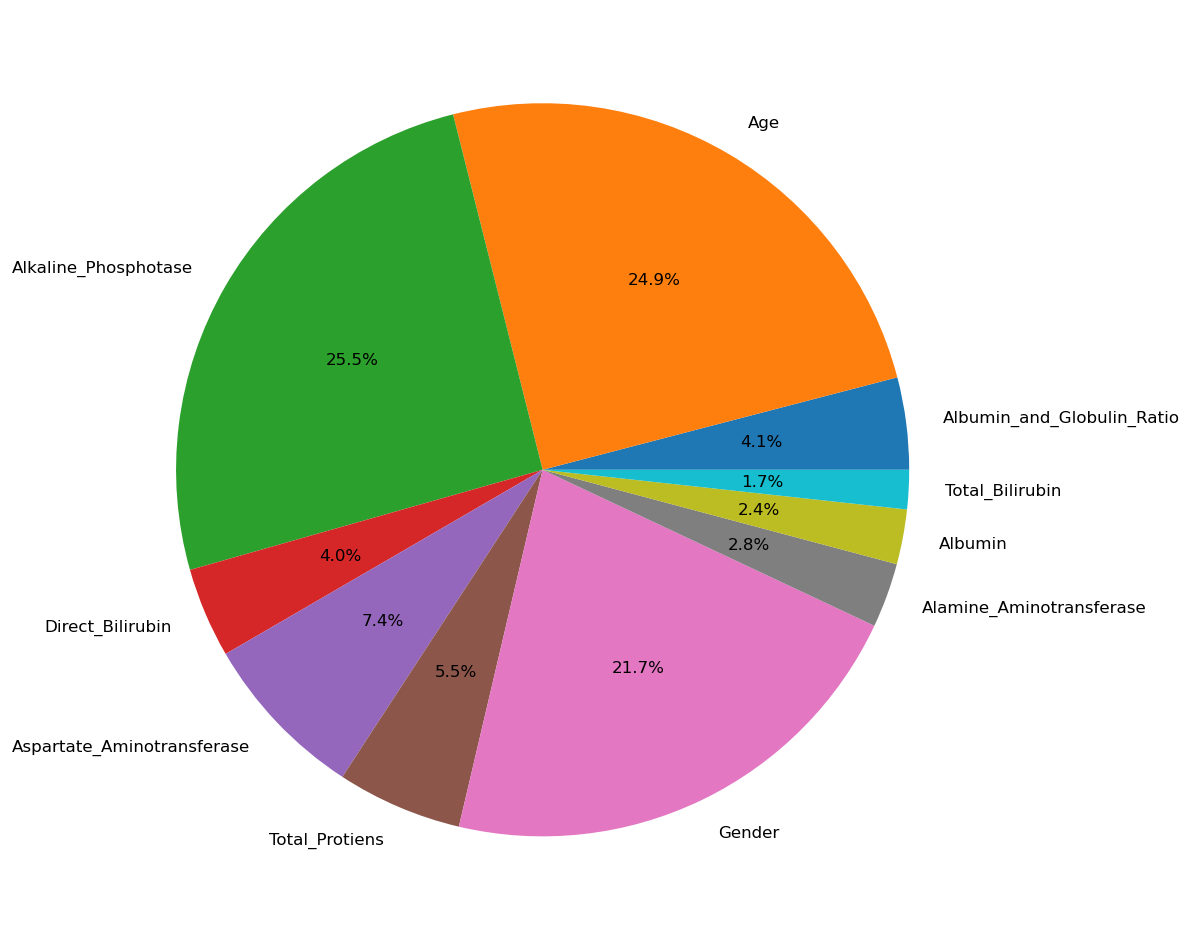

In [116]:
counter = Counter(allData)
features = list(counter.keys())
values = np.array(list(counter.values()))
plt.figure(figsize=(10, 10), dpi = 120)
plt.pie(values, labels = features, autopct='%.1f%%')
plt.tight_layout()
plt.tight_layout()
plt.show()